# Testing Homography / Perspektiv Transformation

In [3]:
import cv2
import numpy as np

In [4]:
# Load the image and the floor plan
image = cv2.imread("Ch4_image.png")
floor_plan = cv2.imread("Ch4_floor_plan.png")

In [5]:
# Convert the images to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2GRAY)

In [6]:
# known camera position
camera_position = np.array([0,0,1])

In [7]:

src_pts = []
dst_pts = []


def select_points_img(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        src_pts.append([x, y])
        print("image point selected:", x, y)
        
def select_points_plan(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        dst_pts.append([x, y])
        print("floor plan point selected:", x, y)

cv2.namedWindow("image")
cv2.setMouseCallback("image", select_points_img)

while True:
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()

cv2.namedWindow("floor_plan")
cv2.setMouseCallback("floor_plan", select_points_plan)

while True:
    cv2.imshow("floor_plan", floor_plan)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

cv2.destroyAllWindows()

# convert the points to numpy array
src_pts = np.array(src_pts)
dst_pts = np.array(dst_pts)

image point selected: 1101 1127
image point selected: 1757 1331
image point selected: 2215 894
image point selected: 2033 360
image point selected: 1682 365
image point selected: 1234 642
image point selected: 1129 1033
floor plan point selected: 358 465
floor plan point selected: 394 280
floor plan point selected: 327 244
floor plan point selected: 208 430
floor plan point selected: 336 581
floor plan point selected: 458 601


: 

In [71]:

# The difference between findHomography and getPerspectiveTransform is that findHomography can handle
# some distortion in the image, while getPerspectiveTransform assumes that the image is not distorted.
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [72]:
H

array([[ 6.48887813e-01,  1.13388419e+00, -4.57417922e+02],
       [-9.28983190e-02,  3.88189764e+00, -3.84529217e+02],
       [-2.83779516e-05,  3.03484886e-03,  1.00000000e+00]])

In [73]:
last_col = np.array([[H[0][2]], [H[1][2]], [H[2][2]]])
last_col

array([[-457.41792208],
       [-384.52921719],
       [   1.        ]])

In [74]:

# Concatenate the last column with the camera position
camera_position = np.array([1100,400,400])
camera_position = np.concatenate((last_col, camera_position.reshape(3,1)), axis=1)
camera_position

array([[-4.57417922e+02,  1.10000000e+03],
       [-3.84529217e+02,  4.00000000e+02],
       [ 1.00000000e+00,  4.00000000e+02]])

In [75]:

# Update the homography matrix
cam_H = np.concatenate((H[:,:2], camera_position), axis=1)
cam_H

array([[ 6.48887813e-01,  1.13388419e+00, -4.57417922e+02,
         1.10000000e+03],
       [-9.28983190e-02,  3.88189764e+00, -3.84529217e+02,
         4.00000000e+02],
       [-2.83779516e-05,  3.03484886e-03,  1.00000000e+00,
         4.00000000e+02]])

In [76]:
x, y = (100, 200)
print(cam_H.shape)

(3, 4)


In [77]:
point2D = np.array([x, y, 1]).reshape(1,3)
point2D.shape

(1, 3)

In [78]:

point3D = np.matmul(point2D, cam_H)
point3D = point3D[0]
point3D

array([ 4.63090891e+01,  8.89770982e+02, -1.22646636e+05,  1.90400000e+05])

In [79]:

# factorize the vector
point3D = point3D / point3D[-1]

# The point3D is now a homogeneous representation of the point, where the last element is 1
print(point3D) 

[ 2.43220006e-04  4.67316692e-03 -6.44152498e-01  1.00000000e+00]


: 

In [22]:

# align the image with the floor plan
height, width = gray_floor_plan.shape
aligned_image = cv2.warpPerspective(image, H, (width, height))

error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3168: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


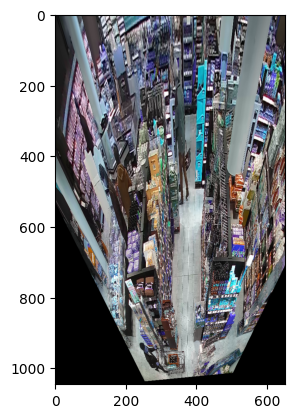

In [11]:
import matplotlib.pyplot as plt

# Display the aligned image
plt.imshow(aligned_image)
plt.show()

In [12]:
# specify the opacity of the overlay
alpha = 0.5 

# create an empty image with the same size as the floor plan
overlay = np.zeros_like(floor_plan)

# copy the aligned image to the overlay
overlay[:, :, :] = aligned_image

# apply the overlay to the floor plan with the specified opacity
result = cv2.addWeighted(floor_plan, 1 - alpha, overlay, alpha, 0)

cv2.imwrite("overlay.jpg", result)

True